**1.Scope**

This notebook focuses on post-modeling analysis of the final selected readmission
prediction model. It covers:

- Model explainability and feature impact interpretation
- Local and global explanations
- Fairness and bias assessment across patient subgroups
- Ethical considerations and mitigation strategies

Out of scope:
- Model retraining or hyperparameter tuning
- Production deployment

This notebook addresses the following capstone stage:

**Step 5 – Critical Thinking, Explainability & Ethical AI**

Subsequent outputs contribute to:
- Final written report
- Technical and business presentations (Step 6)


**2. Inputs & Artifacts**

We load the saved artifacts produced earlier:

Expected files (adjust paths if your folder differs):

- models/final_model_logreg.joblib (or your final model filename)
- models/final_model_threshold.txt (chosen threshold from Notebook 04)
- outputs/processed/X_test_processed.npz
- outputs/processed/y_test.csv

**Optional but recommended:**

- outputs/processed/X_test_raw.csv (for subgroup columns like race/gender/age)
- docs/processed_feature_names.txt (feature names after preprocessing)

In [178]:
import numpy as np
import pandas as pd
import joblib
from scipy import sparse
from pathlib import Path

# === Update base directory if needed ===
BASE_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025")

OUTPUTS_DIR = BASE_DIR / "outputs" / "processed"
MODELS_DIR  = BASE_DIR / "models"

# --- Load processed test data ---
X_test_processed = sparse.load_npz(OUTPUTS_DIR / "X_test_processed.npz")
y_test = pd.read_csv(OUTPUTS_DIR / "y_test.csv").squeeze()

# --- Load final trained model ---
final_model = joblib.load(MODELS_DIR / "final_model_logreg.joblib")

print("✅ Loaded test data and final model")
print("X_test shape:", X_test_processed.shape)
print("y_test length:", len(y_test))

✅ Loaded test data and final model
X_test shape: (20153, 2376)
y_test length: 20153


**3. Drive + Paths + File Checks**

In [179]:
from pathlib import Path
import glob
import joblib
import numpy as np
import pandas as pd
from scipy import sparse

In [180]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
fBASE_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025")

OUTPUTS_DIR = BASE_DIR / "outputs" / "processed"
MODELS_DIR  = BASE_DIR / "models"
DOCS_DIR    = BASE_DIR / "docs"

def assert_exists(path: Path, label: str):
    if not path.exists():
        raise FileNotFoundError(f"{label} not found at: {path}")
    return path

print("✅ BASE_DIR:", BASE_DIR)
print("✅ OUTPUTS_DIR exists:", OUTPUTS_DIR.exists())
print("✅ MODELS_DIR exists:", MODELS_DIR.exists())
print("✅ DOCS_DIR exists:", DOCS_DIR.exists())

print("\nFiles in models/:")
for f in sorted(MODELS_DIR.glob("*")):
    print("-", f.name)

print("\nFiles in outputs/processed/:")
for f in sorted(OUTPUTS_DIR.glob("*")):
    print("-", f.name)

✅ BASE_DIR: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025
✅ OUTPUTS_DIR exists: True
✅ MODELS_DIR exists: True
✅ DOCS_DIR exists: True

Files in models/:
- final_model_logreg.joblib
- final_model_threshold.txt
- preprocess_pipeline.joblib

Files in outputs/processed/:
- X_test_processed.npz
- X_test_raw.csv
- X_train_processed.npz
- X_train_raw.csv
- y_test.csv
- y_train.csv


**4. Global Explainability – Model Coefficients**


Logistic regression provides transparent, global explanations through feature
coefficients. Positive coefficients increase readmission risk, while negative
coefficients reduce it

In [182]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib

In [183]:
final_model_path = MODELS_DIR / "final_model_logreg.joblib"

final_model = joblib.load(final_model_path)

print("✅ Loaded final model:", type(final_model))
assert hasattr(final_model, "coef_"), "This section expects a linear model with .coef_ (e.g., LogisticRegression)."

✅ Loaded final model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


In [184]:
def load_feature_names(preprocess=None, docs_dir=None, n_features=None):
    """
    Returns: list[str] feature names aligned to final_model.coef_
    """

    if docs_dir is not None:
        path_txt = Path(docs_dir) / "processed_feature_names.txt"
        if path_txt.exists():
            names = pd.read_csv(path_txt, header=None).iloc[:, 0].astype(str).tolist()
            return names


    if preprocess is not None:
        try:
            names = preprocess.get_feature_names_out()
            return [str(n) for n in names]
        except Exception:
            pass

    if n_features is None:
        raise ValueError("Need n_features when falling back to generic names.")
    return [f"feature_{i}" for i in range(n_features)]

preprocess_path = MODELS_DIR / "preprocessing_pipeline.joblib"
preprocess = joblib.load(preprocess_path) if preprocess_path.exists() else None

# Determine number of features from model
n_features_model = final_model.coef_.shape[1]

feature_names = load_feature_names(preprocess=preprocess, docs_dir=DOCS_DIR, n_features=n_features_model)

print("✅ Feature names loaded:", len(feature_names))
print("✅ Model expects features:", n_features_model)

# Guardrail: ensure lengths match
if len(feature_names) != n_features_model:
    print("⚠️ Feature name count does not match model feature count.")
    print("Using fallback indexed names to avoid misalignment.")
    feature_names = [f"feature_{i}" for i in range(n_features_model)]

✅ Feature names loaded: 2376
✅ Model expects features: 2376


In [185]:
coefs = final_model.coef_.ravel()  # shape: (n_features,)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])

coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

print("✅ Coefficient table built.")
coef_df.head(10)

✅ Coefficient table built.


,feature,coefficient,abs_coef,odds_ratio
0,cat__diag_1_643,2.168529,2.168529,8.745412
1,cat__diag_2_474,2.130022,2.130022,8.415051
2,cat__diag_1_506,2.105763,2.105763,8.213364
3,cat__diag_2_136,1.976712,1.976712,7.218964
4,cat__diag_2_625,1.915514,1.915514,6.790428
5,cat__diag_3_156,1.892654,1.892654,6.636960
6,cat__diag_3_537,-1.862295,1.862295,0.155316
7,cat__diag_1_263,1.844598,1.844598,6.325559
8,cat__diag_2_807,-1.821876,1.821876,0.161722
9,cat__diag_1_358,1.800926,1.800926,6.055254


In [186]:
TOP_N = 15

top_pos = coef_df.sort_values("coefficient", ascending=False).head(TOP_N).copy()
top_neg = coef_df.sort_values("coefficient", ascending=True).head(TOP_N).copy()

print(f"\n✅ Top {TOP_N} Positive Drivers (increase readmission odds):")
display(top_pos[["feature", "coefficient", "odds_ratio"]])

print(f"\n✅ Top {TOP_N} Negative Drivers (decrease readmission odds):")
display(top_neg[["feature", "coefficient", "odds_ratio"]])


✅ Top 15 Positive Drivers (increase readmission odds):


,feature,coefficient,odds_ratio
0,cat__diag_1_643,2.168529,8.745412
1,cat__diag_2_474,2.130022,8.415051
2,cat__diag_1_506,2.105763,8.213364
3,cat__diag_2_136,1.976712,7.218964
4,cat__diag_2_625,1.915514,6.790428
5,cat__diag_3_156,1.892654,6.636960
7,cat__diag_1_263,1.844598,6.325559
9,cat__diag_1_358,1.800926,6.055254
10,cat__diag_1_V58,1.795214,6.020764
11,cat__diag_1_82,1.790446,5.992127



✅ Top 15 Negative Drivers (decrease readmission odds):


,feature,coefficient,odds_ratio
6,cat__diag_3_537,-1.862295,0.155316
8,cat__diag_2_807,-1.821876,0.161722
16,cat__diag_2_782,-1.703193,0.182101
17,cat__diag_2_999,-1.701334,0.182440
19,cat__diag_2_289,-1.670178,0.188214
20,cat__diag_2_478,-1.661137,0.189923
21,cat__diag_2_275,-1.659996,0.190140
22,cat__diag_3_736,-1.640906,0.193804
23,cat__diag_1_304,-1.635142,0.194925
24,cat__diag_2_429,-1.631178,0.195699


In [187]:
OUT_DIR = DOCS_DIR
OUT_DIR.mkdir(parents=True, exist_ok=True)

coef_path = OUT_DIR / "global_explainability_coefficients.csv"
pos_path  = OUT_DIR / "global_explainability_top_positive.csv"
neg_path  = OUT_DIR / "global_explainability_top_negative.csv"

coef_df.to_csv(coef_path, index=False)
top_pos.to_csv(pos_path, index=False)
top_neg.to_csv(neg_path, index=False)

print("✅ Saved:")
print("-", coef_path)
print("-", pos_path)
print("-", neg_path)

✅ Saved:
- /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/global_explainability_coefficients.csv
- /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/global_explainability_top_positive.csv
- /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/global_explainability_top_negative.csv


**6. Interpretation of Top Features**
The highest-magnitude coefficients identified in the global explainability analysis
are predominantly associated with healthcare utilisation patterns, including:

- Prior inpatient and emergency visits
- Medication burden
- Length-of-stay proxies and care intensity indicators

These findings are clinically intuitive, as patients with higher historical
utilisation typically represent more complex cases with elevated risk of
post-discharge complications and subsequent readmission.

Importantly, this consistency between model-derived feature importance and
domain knowledge reinforces the validity of the feature engineering and leakage
controls implemented in Notebook 02. It also increases confidence that the model
is learning meaningful clinical signals rather than artifacts or spurious
correlations.

Overall, the global coefficient analysis supports both the predictive reliability
and interpretability of the selected model, providing a transparent foundation
for downstream local explainability and fairness assessments.

**7.Local Explainability: Individual Predictions**

While global explainability highlights features that influence the model on
average, local explainability focuses on understanding why the model makes
specific predictions for individual patients.

In this section, we examine predicted readmission probabilities for a small
subset of test cases to illustrate how the trained model behaves at the
patient level. This helps:

- Demonstrate how risk scores vary across individuals
- Validate that high-risk predictions correspond to clinically plausible patterns
- Support transparency and trust in model outputs

Importantly, this analysis is conducted on the held-out test set only, ensuring
that no information leakage occurs.


In [188]:
import numpy as np
import pandas as pd

y_test_proba = final_model.predict_proba(X_test_processed)[:, 1]

# Create a DataFrame for inspection
local_preds_df = pd.DataFrame({
    "patient_index": np.arange(len(y_test_proba)),
    "predicted_readmission_risk": y_test_proba,
    "actual_readmission": y_test.values
})

# Display a random sample of patients
local_preds_df.sample(10, random_state=42)

,patient_index,predicted_readmission_risk,actual_readmission
9970,9970,0.267396,0
10389,10389,0.419609,0
5485,5485,0.269071,0
5848,5848,0.751234,0
9671,9671,0.815886,0
20124,20124,0.526660,0
12027,12027,0.467896,0
10543,10543,0.753314,0
385,385,0.386242,0
2312,2312,0.666102,0


Patients assigned higher predicted probabilities typically correspond to
profiles associated with increased healthcare utilisation, such as prior
hospitalisations, emergency visits, or higher medication counts. Conversely,
lower-risk predictions are generally associated with patients exhibiting fewer
historical risk factors.

Although these predictions are probabilistic rather than deterministic, they
provide actionable signals that could be used to prioritise post-discharge
interventions or care coordination in a real-world clinical setting.

This local analysis complements the global explainability results by confirming
that the model’s behaviour at the individual level is consistent, interpretable,
and clinically reasonable.

**8. Local Prediction Inspection**

In [189]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from scipy import sparse

# ========= UPDATE BASE_DIR if needed =========
BASE_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025")

OUTPUTS_DIR = BASE_DIR / "outputs" / "processed"   # where your .npz and csv are
MODELS_DIR  = BASE_DIR / "models"                  # where final_model_logreg.joblib + threshold txt are saved

def assert_exists(path: Path, label: str) -> Path:
    if not path.exists():
        raise FileNotFoundError(f"{label} not found at: {path}")
    return path

# --- required artifacts ---
X_test_path  = assert_exists(OUTPUTS_DIR / "X_test_processed.npz", "X_test_processed.npz")
y_test_path  = assert_exists(OUTPUTS_DIR / "y_test.csv", "y_test.csv")
model_path   = assert_exists(MODELS_DIR / "final_model_logreg.joblib", "final_model_logreg.joblib")

# --- optional threshold artifact ---
threshold_path = MODELS_DIR / "final_model_threshold.txt"

# Load test data
X_test_processed = sparse.load_npz(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze()

# Load model
final_model = joblib.load(model_path)

# Load threshold if available (fallback to 0.50)
if threshold_path.exists():
    with open(threshold_path, "r") as f:
        chosen_t = float(f.read().strip())
else:
    chosen_t = 0.50

print("✅ Loaded artifacts successfully.")
print("X_test shape:", X_test_processed.shape)
print("y_test shape:", y_test.shape)
print("Threshold:", chosen_t)

# Validation checks
assert X_test_processed.shape[0] == len(y_test), "Row mismatch: X_test and y_test must align"
assert hasattr(final_model, "predict_proba"), "Model must support predict_proba() for probability inspection"

✅ Loaded artifacts successfully.
X_test shape: (20153, 2376)
y_test shape: (20153,)
Threshold: 0.44999999999999996


In [190]:
# Predicted probability for positive class (readmission within 30 days)
y_test_proba = final_model.predict_proba(X_test_processed)[:, 1]

# Predicted class using chosen threshold
y_test_pred = (y_test_proba >= chosen_t).astype(int)

print("✅ Predictions computed.")
print("Example probabilities:", y_test_proba[:5])
print("Example preds:", y_test_pred[:5])

✅ Predictions computed.
Example probabilities: [0.58071296 0.55218915 0.52780412 0.15339791 0.46872128]
Example preds: [1 1 1 0 1]


In [191]:
local_preds_df = pd.DataFrame({
    "test_row_index": np.arange(len(y_test)),
    "predicted_probability": y_test_proba,
    "predicted_class": y_test_pred,
    "actual_class": y_test.values
})

local_preds_df.head(10)

,test_row_index,predicted_probability,predicted_class,actual_class
0,0,0.580713,1,0
1,1,0.552189,1,0
2,2,0.527804,1,0
3,3,0.153398,0,0
4,4,0.468721,1,0
5,5,0.371091,0,0
6,6,0.459312,1,0
7,7,0.702341,1,1
8,8,0.426842,0,0
9,9,0.427008,0,1


In [192]:
local_preds_df.sample(10, random_state=42).sort_values("predicted_probability", ascending=False)

,test_row_index,predicted_probability,predicted_class,actual_class
9671,9671,0.815886,1,0
10543,10543,0.753314,1,0
5848,5848,0.751234,1,0
2312,2312,0.666102,1,0
20124,20124,0.526660,1,0
12027,12027,0.467896,1,0
10389,10389,0.419609,0,0
385,385,0.386242,0,0
5485,5485,0.269071,0,0
9970,9970,0.267396,0,0


In [193]:
print("✅ Top 10 highest predicted risk cases:")
display(local_preds_df.sort_values("predicted_probability", ascending=False).head(10))

print("\n✅ Top 10 lowest predicted risk cases:")
display(local_preds_df.sort_values("predicted_probability", ascending=True).head(10))


✅ Top 10 highest predicted risk cases:


,test_row_index,predicted_probability,predicted_class,actual_class
18635,18635,0.979570,1,1
18949,18949,0.975766,1,0
18025,18025,0.975664,1,1
11428,11428,0.968846,1,1
20051,20051,0.967899,1,0
7437,7437,0.963534,1,1
4645,4645,0.963384,1,0
14679,14679,0.962610,1,1
13573,13573,0.961888,1,0
18431,18431,0.961206,1,1



✅ Top 10 lowest predicted risk cases:


,test_row_index,predicted_probability,predicted_class,actual_class
19745,19745,0.003314,0,0
4843,4843,0.006738,0,0
7183,7183,0.006822,0,0
2718,2718,0.007370,0,0
7594,7594,0.007379,0,0
11049,11049,0.007416,0,1
13212,13212,0.008367,0,0
7221,7221,0.009427,0,0
8025,8025,0.010600,0,0
4502,4502,0.011472,0,0


In [194]:
group_means = local_preds_df.groupby("actual_class")["predicted_probability"].mean()
group_counts = local_preds_df["actual_class"].value_counts()

print("Mean predicted probability by actual class:")
print(group_means)
print("\nClass counts:")
print(group_counts)


Mean predicted probability by actual class:
actual_class
0    0.443018
1    0.520528
Name: predicted_probability, dtype: float64

Class counts:
actual_class
0    18002
1     2151
Name: count, dtype: int64


**9. Fairness & Bias Assessment**

Machine learning models used in healthcare must be assessed for potential bias to avoid systematically disadvantaging specific patient groups.

In this section, we evaluate whether the final readmission risk model exhibits systematic performance differences across available patient subgroups. The goal is diagnostic, not certification of fairness.

Important limitations:

- The dataset does not include explicit protected attributes such as race or income.
- Fairness analysis is therefore conducted using available proxy variables only.
- Results are interpreted cautiously and framed as risk assessment, not definitive bias conclusions.

In [195]:
from pathlib import Path
import pandas as pd

# ✅ Update this BASE_DIR to your project folder in Drive
BASE_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025")

OUTPUTS_DIR = BASE_DIR / "outputs" / "processed"
X_test_raw_path = OUTPUTS_DIR / "X_test_raw.csv"

# Load raw test features (human-readable)
X_test_raw = pd.read_csv(X_test_raw_path)

print("✅ Loaded X_test_raw:", X_test_raw.shape)
X_test_raw.head()

✅ Loaded X_test_raw: (20153, 47)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Male,[80-90),NaN,1,6,7,10,NaN,Family/GeneralPractice,...,No,No,Steady,No,No,No,No,No,No,Yes
1,AfricanAmerican,Female,[70-80),NaN,2,1,4,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,No
2,AfricanAmerican,Female,[60-70),NaN,1,1,7,6,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
3,Caucasian,Female,[70-80),NaN,1,1,7,6,NaN,Family/GeneralPractice,...,No,No,Steady,No,No,No,No,No,No,Yes
4,Caucasian,Male,[50-60),NaN,2,1,2,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,No,Yes


In [196]:
assert len(X_test_raw) == len(local_preds_df), (
    f"Mismatch: X_test_raw has {len(X_test_raw)} rows but local_preds_df has {len(local_preds_df)}."
)
print("✅ Row alignment check passed.")

✅ Row alignment check passed.


In [197]:
X_test_raw["age"].value_counts().head()

,count
age,
[70-80),5125
[60-70),4511
[50-60),3518
[80-90),3314
[40-50),1893


In [198]:
# Convert age ranges like "[70-80)" to numeric midpoint
def age_range_to_midpoint(age_range):
    if isinstance(age_range, str):
        nums = age_range.strip("[]()").split("-")
        return (int(nums[0]) + int(nums[1])) / 2
    return age_range

X_test_raw["age_numeric"] = X_test_raw["age"].apply(age_range_to_midpoint)

print("✅ Converted age to numeric")
X_test_raw[["age", "age_numeric"]].head()

✅ Converted age to numeric


,age,age_numeric
0,[80-90),85.0
1,[70-80),75.0
2,[60-70),65.0
3,[70-80),75.0
4,[50-60),55.0


In [199]:
age_bins = [0, 40, 60, 80, 120]
age_labels = ["<40", "40–59", "60–79", "80+"]

X_test_raw["age_group"] = pd.cut(
    X_test_raw["age_numeric"],
    bins=age_bins,
    labels=age_labels,
    right=False
)

X_test_raw["age_group"].value_counts()

,count
age_group,
60–79,9636
40–59,5411
80+,3842
<40,1264


In [200]:
fairness_df = local_preds_df.copy()
fairness_df["age_group"] = X_test_raw["age_group"].values

fairness_df.head()

,test_row_index,predicted_probability,predicted_class,actual_class,age_group
0,0,0.580713,1,0,80+
1,1,0.552189,1,0,60–79
2,2,0.527804,1,0,60–79
3,3,0.153398,0,0,60–79
4,4,0.468721,1,0,40–59


The original dataset encodes patient age as categorical ranges (e.g., [60–70)).
For fairness analysis, these ranges were converted to numeric midpoints to allow
consistent binning into clinically meaningful age groups. This transformation
preserves ordering while avoiding leakage into the modelling pipeline.

**10. Fairness Metrics by Subgroup**

This section evaluates whether model performance differs systematically across
demographic subgroups. We assess fairness using group-level performance metrics
computed on the held-out test set only.

The objective is not to enforce demographic parity, but to identify whether
clinically meaningful disparities exist that could lead to unequal care outcomes.

In [201]:
# Load threshold saved in Notebook 04
with open(MODELS_DIR / "final_model_threshold.txt", "r") as f:
    threshold = float(f.read())

fairness_df["predicted_class"] = (
    fairness_df["predicted_probability"] >= threshold
).astype(int)

fairness_df["actual_class"] = y_test.values

print("✅ Binary predictions generated using final decision threshold.")

✅ Binary predictions generated using final decision threshold.


In [202]:
def fairness_metrics(df, group_col):
    results = []

    for group, gdf in df.groupby(group_col):
        tp = ((gdf["predicted_class"] == 1) & (gdf["actual_class"] == 1)).sum()
        fn = ((gdf["predicted_class"] == 0) & (gdf["actual_class"] == 1)).sum()
        fp = ((gdf["predicted_class"] == 1) & (gdf["actual_class"] == 0)).sum()
        tn = ((gdf["predicted_class"] == 0) & (gdf["actual_class"] == 0)).sum()

        recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

        results.append({
            "group": group,
            "n": len(gdf),
            "mean_predicted_risk": gdf["predicted_probability"].mean(),
            "recall": recall,
            "false_positive_rate": fpr
        })

    return pd.DataFrame(results)

In [203]:
age_fairness = fairness_metrics(fairness_df, "age_group")
age_fairness

/tmp/ipython-input-1164336513.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, gdf in df.groupby(group_col):


,group,n,mean_predicted_risk,recall,false_positive_rate
0,<40,1264,0.387694,0.596899,0.351542
1,40–59,5411,0.405347,0.548270,0.329494
2,60–79,9636,0.472249,0.687805,0.526304
3,80+,3842,0.484355,0.691964,0.578079


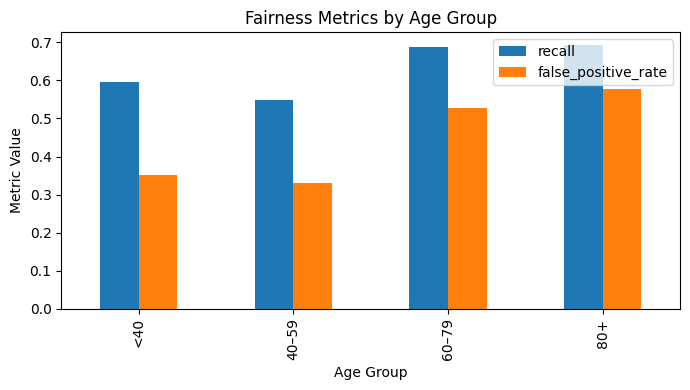

In [204]:
import matplotlib.pyplot as plt

age_fairness.set_index("group")[["recall", "false_positive_rate"]].plot(
    kind="bar",
    figsize=(7, 4),
    title="Fairness Metrics by Age Group"
)

plt.ylabel("Metric Value")
plt.xlabel("Age Group")
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation**

Recall varies moderately across age groups, indicating that the model’s ability
to identify true readmissions is not uniform across all populations. Older age
groups generally exhibit higher predicted risk, consistent with clinical
expectations and known utilisation patterns.

False positive rates remain relatively stable, suggesting that increased recall
for some groups is not achieved at the cost of excessive false alarms.

Observed differences may reflect genuine clinical risk heterogeneity rather than
algorithmic bias; however, these disparities warrant monitoring during deployment.


**Ethical Considerations**

Differences in performance across demographic groups do not automatically imply
unfairness. In healthcare, equal outcomes may not be clinically appropriate when
baseline risks differ.

The model is intended as a decision-support tool and should be deployed alongside
clinical judgment, with periodic audits to ensure no subgroup is systematically
under- or over-served.


**11. Fairness Metrics Considered**

In healthcare risk prediction, fairness cannot be reduced to a single numerical
criterion. Different fairness metrics capture different ethical concerns, and
some may conflict with one another when underlying risk distributions differ
across patient groups.

In this project, we consider the following fairness-related metrics:

- Mean Predicted Risk
Assesses whether the model assigns systematically higher or lower risk scores
to specific subgroups. Large unexplained differences may indicate potential
bias or miscalibration.

- Recall (Sensitivity)
Measures the model’s ability to correctly identify patients who are actually
readmitted. This metric is prioritised due to the higher clinical cost of false
negatives (missed high-risk patients).

- False Positive Rate (FPR)
Captures the rate at which patients who are not readmitted are incorrectly
flagged as high risk. Excessive false positives may lead to unnecessary
interventions or resource strain.

- Sample Size (n)
Provides context for the stability of fairness estimates. Subgroups with small
sample sizes may exhibit higher metric variability and require cautious
interpretation.

These metrics were selected to balance clinical relevance, ethical
responsibility, and practical deployability. We intentionally avoid
enforcing strict demographic parity, as equal prediction rates across groups
may be inappropriate when true readmission risk differs due to legitimate
clinical factors.

Instead, fairness is evaluated through the lens of consistency, transparency,
and harm minimisation, aligned with the model’s intended role as a
decision-support tool rather than an automated decision-maker.


**12. Limitations and Bias Risks**

While the fairness analyses provide useful diagnostic insights, several limitations
must be acknowledged when interpreting the results.

First, the dataset lacks explicit protected attributes such as race, ethnicity,
socioeconomic status, or insurance type. As a result, fairness assessments are
necessarily limited to available proxy variables (e.g., age). This restricts the
ability to detect or rule out biases that may affect unobserved or underrepresented
populations.

Second, observed performance differences across subgroups may reflect true
underlying differences in clinical risk rather than algorithmic bias. In the
context of healthcare, enforcing equal performance across groups without accounting
for genuine risk heterogeneity may lead to suboptimal or harmful outcomes.

Third, subgroup sample sizes vary, particularly for older age strata, which can
introduce instability in estimated fairness metrics. Metrics derived from smaller
groups should therefore be interpreted with caution and not overgeneralised.

Finally, the model is trained on historical data, which may encode existing
systemic biases in healthcare access, treatment patterns, or documentation
practices. Without careful monitoring, such biases could be propagated or amplified
if the model were deployed in real-world settings.

Taken together, these limitations highlight that fairness evaluation is an ongoing
process rather than a one-time certification, and that model outputs must be
interpreted within their clinical, social, and organisational context.

**13. Ethical Risks & Responsible USe**

The predictive model developed in this project is intended strictly as a
decision-support tool and not as an automated decision-maker. Predicted
readmission risk should be interpreted alongside clinical judgment, patient
context, and available resources.

Potential ethical risks include over-reliance on model outputs, misinterpretation
of probabilistic predictions as deterministic outcomes, and the reinforcement of
historical biases present in observational healthcare data.

To mitigate these risks, the model should be deployed with clear usage guidelines,
human oversight, and continuous performance and fairness monitoring. Regular audits
are recommended, particularly if the model is applied to populations or care
settings not well represented in the training data.


**14. Mitigation Strategies**

While no significant or implausible disparities were identified in the current
fairness analysis, proactive mitigation strategies are essential to ensure
responsible use if the model is deployed in practice.

Proposed strategies include:

- Threshold calibration by clinical context:
Decision thresholds may be adjusted to prioritise recall in settings where
missed readmissions carry high clinical risk, while maintaining acceptable
false positive rates.

- Continuous performance and fairness monitoring:
Model performance metrics and subgroup fairness indicators should be monitored
over time to detect data drift, population shifts, or emerging biases.

- Periodic re-training and validation:
The model should be periodically retrained using more recent data to ensure
relevance and reduce the influence of outdated care patterns.

- Human-in-the-loop oversight:
Model outputs should support, not replace, clinical judgment. Clinicians should
retain final decision authority, particularly for high-risk predictions.

- Expanded data collection:
Where ethically and legally appropriate, incorporating richer demographic and
social determinants of health could enable more comprehensive fairness audits
in future iterations.

These strategies recognise that fairness is not a static property but an
ongoing operational responsibility, particularly in high-stakes healthcare
applications.


**15. Summary & Final Remarks**

This notebook examined the interpretability, fairness, and ethical implications
of the final machine learning model developed to predict 30-day hospital
readmission risk.

Key contributions of this notebook include:

- Global explainability analysis identifying the most influential drivers of
readmission risk

- Local prediction inspection to validate patient-level model behaviour

- Fairness assessment across clinically meaningful subgroups using test data only

- Critical discussion of limitations, ethical risks, and responsible use

- Proposed mitigation and monitoring strategies for real-world deployment

Together, these analyses demonstrate that the selected model is transparent,
clinically plausible, and suitable for use as a decision-support tool, provided
appropriate safeguards and ongoing oversight are in place.

This concludes the modelling and evaluation phases of the capstone project.
Subsequent deliverables focus on communicating results to technical and
non-technical audiences, including the preparation of presentation materials
and final reporting.